In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Things to include in the notebook
- Difference between training on the same dataset(s) and crossing dataset
- Try to have it random if it should train on an image from MNIST or SVHN. 
- Try training with different types of preprocessing and data augmentation


# Startphase

## Loading the MNIST dataset


In [2]:

from torchvision.transforms import ToTensor
import torchvision
import torch

# These hyperparameters should be further tested
batch_size = 4
num_workers = 4

mnist_train_dataset = torchvision.datasets.MNIST(root="data", download=True, transform=ToTensor(), train=True)

## Loading the SVHN dataset

In [3]:
svhn_train_dataset = torchvision.datasets.SVHN(root="data", split='train', download=True, transform=ToTensor())


Using downloaded and verified file: data/train_32x32.mat


## Visualizing the MNIST dataset

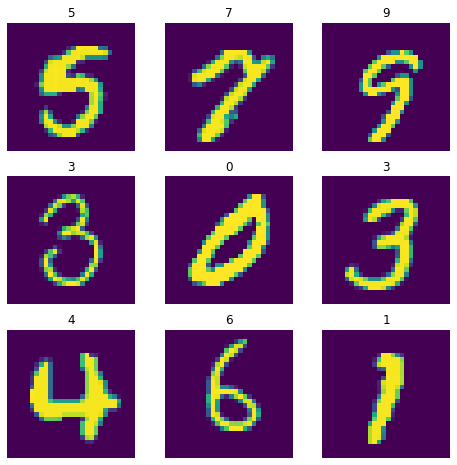

In [4]:
from matplotlib import pyplot as plt

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(mnist_train_dataset), size=(1,)).item()
    img, label = mnist_train_dataset[sample_idx]
    ax = figure.add_subplot(rows, cols, i)
    ax.set_title(label)
    plt.axis("off")
    plt.imshow(img.squeeze())
plt.show()

## Visualizing the SVHN dataset


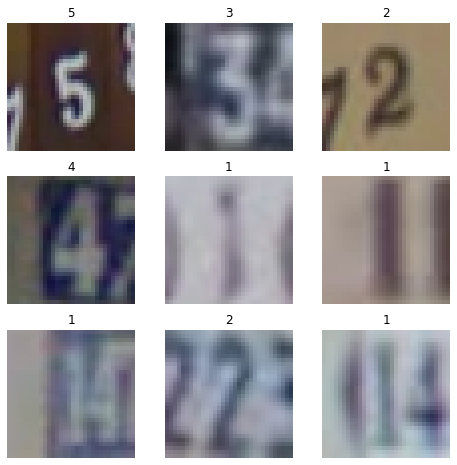

In [5]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(svhn_train_dataset), size=(1,)).item()
    img, label = svhn_train_dataset[sample_idx]
    img = img.permute(1, 2, 0)
    ax1 = figure.add_subplot(rows, cols, i)
    ax1.set_title(label)
    plt.axis("off")
    plt.imshow(img.squeeze())

plt.show()

## Creating 2d-array with all the tensors based on label

In [6]:
import numpy as np

mnist_arr = []
svhn_arr = []

for i in range(10):
    mnist_arr.append([])
    svhn_arr.append([])

for num, item in enumerate(svhn_train_dataset):
    svhn_img = item[0].permute(1, 2, 0)
    svhn_arr[item[1]].append(svhn_img)

for num, item in enumerate(mnist_train_dataset):
    mnist_arr[item[1]].append(item[0])



## Inspecting images at same position

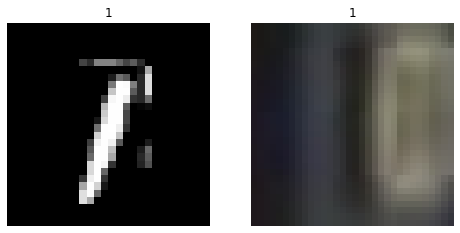

In [7]:
import random

pos1 = random.randint(0, 9)
pos2 = random.randint(0, min(len(mnist_arr), len(svhn_arr)))

figure = plt.figure(figsize=(8, 8))
mnist_img = mnist_arr[pos1][pos2]
svhn_img = svhn_arr[pos1][pos2]

ax = figure.add_subplot(1, 2, 1)
ax.set_title(pos1)
plt.axis("off")
plt.imshow(mnist_img.squeeze(), cmap="gray")
ax = figure.add_subplot(1, 2, 2)
ax.set_title(pos1)
plt.axis("off")
plt.imshow(svhn_img.squeeze())

plt.show()



## Visualizing the distribution of labels from both datasets

3.6.2


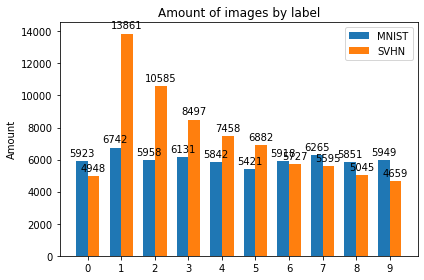

In [8]:
import matplotlib

print(matplotlib.__version__)

labels = np.arange(0, 10)
len_mnist = [0] * 10
len_svhn = [0] * 10

for i in range(10):
    len_mnist[i] = len(mnist_arr[i])
    len_svhn[i] = len(svhn_arr[i])

width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(labels - width / 2, len_mnist, width, label='MNIST')
rects2 = ax.bar(labels + width / 2, len_svhn, width, label='SVHN')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Amount')
ax.set_title('Amount of images by label')
ax.set_xticks(labels, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

# Data preprocessing - Exploration phase


## Grayscale



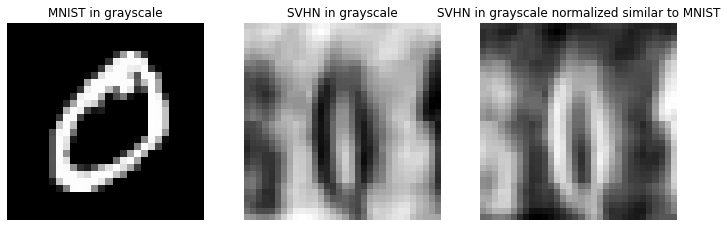

In [9]:
import torchvision.transforms as T
import cv2 as cv

test_img_mnist = mnist_arr[0][0]
test_img_svhn = svhn_arr[0][0]

test_img_svhn = torch.movedim(test_img_svhn, 2, 0)

gray_svhn = T.Grayscale()(test_img_svhn)

gray_svhn2 = gray_svhn

gray_svhn = torch.movedim(gray_svhn, 0, 2)

gray_svhn2 = gray_svhn2.detach().numpy()
gray_svhn2 = cv.normalize(gray_svhn2, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
gray_svhn2 = 255 - gray_svhn2

figure = plt.figure(figsize=(12, 8))
ax = figure.add_subplot(2, 3, 1)
plt.axis("off")
ax.set_title("MNIST in grayscale")
plt.imshow(test_img_mnist.squeeze(), cmap="gray")

ax = figure.add_subplot(2, 3, 2)
plt.axis("off")
ax.set_title("SVHN in grayscale")
plt.imshow(gray_svhn.squeeze(), cmap="gray")

ax = figure.add_subplot(2, 3, 3)
plt.axis("off")
ax.set_title("SVHN in grayscale normalized similar to MNIST")
plt.imshow(gray_svhn2.squeeze(), cmap="gray")

plt.show()


## Threshold


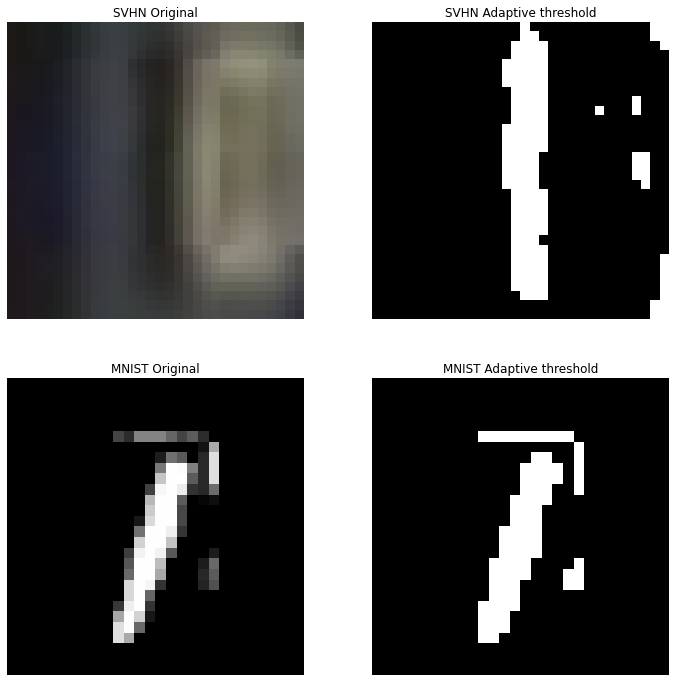

In [10]:
svhn_img = svhn_arr[pos1][pos2]
mnist_img = mnist_arr[pos1][pos2]

svhn = svhn_img.detach().numpy()
mnist = mnist_img.detach().numpy()

svhn_grey = cv.normalize(svhn, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
svhn_grey = cv.cvtColor(svhn_grey, cv.COLOR_BGR2GRAY)
svhn_grey = svhn_grey.astype(np.uint8)

#Should find a good number for reduction on adaptive threshold, e.g. the last number
svhn_threshold = cv.adaptiveThreshold(svhn_grey, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 20)
svhn_threshold = cv.bitwise_not(svhn_threshold)

#Threshold reduction number needs to be 0 on mnist
mnist = cv.normalize(mnist, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8UC1)
mnist = mnist.astype(np.uint8)
mnist_threshold = cv.adaptiveThreshold(mnist[0], 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 0)

figure = plt.figure(figsize=(12, 12))

ax = figure.add_subplot(2, 2, 1)
ax.set_title("SVHN Original")
plt.axis("off")
plt.imshow(svhn.squeeze(), cmap="gray")

ax = figure.add_subplot(2, 2, 2)
ax.set_title("SVHN Adaptive threshold")
plt.axis("off")
plt.imshow(svhn_threshold.squeeze(), cmap="gray")

ax = figure.add_subplot(2, 2, 3)
ax.set_title("MNIST Original")
plt.axis("off")
plt.imshow(mnist.squeeze(), cmap="gray")

ax = figure.add_subplot(2, 2, 4)
ax.set_title("MNIST Adaptive threshold")
plt.axis("off")
plt.imshow(mnist_threshold.squeeze(), cmap="gray")

plt.show()

## Equalize Hist and CLAHE

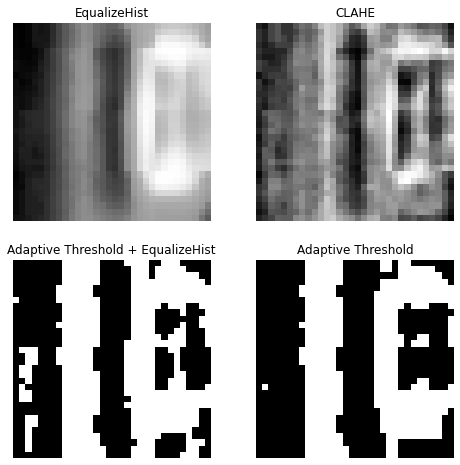

In [11]:
image = svhn_arr[pos1][pos2]

image = image.detach().numpy()
image = cv.normalize(image, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
image = image.astype(np.uint8)

image2 = image
image4 = image

image = cv.equalizeHist(image)
clahe = cv.createCLAHE(clipLimit=3., )
image2 = clahe.apply(image2)

image3 = cv.adaptiveThreshold(image, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 2)
image4 = cv.adaptiveThreshold(image4, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 0)

figure = plt.figure(figsize=(8, 8))

ax = figure.add_subplot(2, 2, 1)
ax.set_title("EqualizeHist")
plt.axis("off")
plt.imshow(image.squeeze(), cmap="gray")
ax = figure.add_subplot(2, 2, 2)
ax.set_title("CLAHE")
plt.axis("off")
plt.imshow(image2.squeeze(), cmap="gray")
ax = figure.add_subplot(2, 2, 3)
ax.set_title("Adaptive Threshold + EqualizeHist")
plt.axis("off")
plt.imshow(image3.squeeze(), cmap="gray")
ax = figure.add_subplot(2, 2, 4)
ax.set_title("Adaptive Threshold")
plt.axis("off")
plt.imshow(image4.squeeze(), cmap="gray")

# Defining the model

### Using CUDA if possible

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cpu


## Defining the loss function

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class ContrastiveLoss(nn.Module):

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2)
            + (label)
            * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )

        return loss_contrastive

## Defining siamese network model¶

In [14]:
import torch.nn as nn


class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(16 * 7 * 7, 10)
        )

    def forward_once(self, x):
        # Forward pass
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2

## Setting up the custom dataset

In [15]:
import torchvision
from torch.utils.data import Dataset


class SiameseDataset(Dataset):
    def __init__(self, train: bool, mnist=False, svhn=False, mix=False):
        self.mnist_dataset = None
        self.svhn_dataset = None

        if mnist:
            self.mnist_dataset = torchvision.datasets.MNIST("files", train=train, download=True,
                                                        transform=torchvision.transforms.ToTensor())
        if svhn:
            split = ""
            if train:
                split = "train"
            else:
                split = "test"

            self.svhn_dataset = torchvision.datasets.SVHN(root="data", split=split, download=True, transform=ToTensor())

        # used to prepare the labels and images path
        self.pairs = make_pairs(mix, self.mnist_dataset, self.svhn_dataset)

    def __getitem__(self, index):
        return self.dataset.data[self.pairs[index][0]].float().unsqueeze(0), self.dataset.data[
            self.pairs[index][1]].float().unsqueeze(0), self.pairs[index][2]

    def __len__(self):
        return len(self.pairs)


def make_pairs(mix, mnist = None, svhn = None):
    pairs = []

    num_classes = 10

    mnist_idx = 0
    svhn_idx = 0

    if mix and mnist and svhn:
        ### Add mixing of datasets
        mnist_labels = mnist.targets
        svhn_labels = svhn.labels
        mnist_idx = [np.where(mnist_labels == i)[0] for i in range(0, num_classes)]
        svhn_idx = [np.where(svhn_labels == i)[0] for i in range(0, num_classes)]


        print(mnist_labels)
        print("AAAA")
        #Use mnist since it has fewest examples
        for anchor_idx in range(len(mnist_labels)):
            mnist_label = mnist_labels[anchor_idx]
            svhn_label = svhn_labels[anchor_idx]

            same_dataset = np.random.randint(0, 1)
            if same_dataset:
                pos_mnist_idx = np.random.choice(mnist_idx[mnist_label])
                pos_svhn_idx = np.random.choice(svhn_idx[svhn_label])
        for anchor_idx in range(len(svhn_labels)):
            break
            pairs.append([anchor_idx])

        return pairs

    if svhn:
        svhn_labels = svhn.labels
        svhn_idx = [np.where(svhn_labels == i)[0] for i in range(0, num_classes)]

        for anchor_idx in range(len(svhn_labels)):
            label = svhn_labels[anchor_idx]

            pos_idx = np.random.choice(svhn_idx[label])

            pairs.append([anchor_idx, pos_idx, 0])

            negative_label = np.random.randint(0, num_classes - 1)
            while negative_label == label:
                negative_label = np.random.randint(0, num_classes - 1)

            neg_idx = np.random.choice(svhn_idx[negative_label])

            pairs.append([anchor_idx, neg_idx, 1])
    if mnist:
        ##TODO start from prev index in pairs
        mnist_labels = mnist.targets
        mnist_idx = [np.where(mnist_labels == i)[0] for i in range(0, num_classes)]

        for anchor_idx in range(len(mnist_labels)):
            label = mnist_labels[anchor_idx]

            pos_idx = np.random.choice(mnist_idx[label])

            pairs.append([anchor_idx, pos_idx, 0])

            negative_label = np.random.randint(0, num_classes - 1)
            while negative_label == label:
                negative_label = np.random.randint(0, num_classes - 1)

            neg_idx = np.random.choice(mnist_idx[negative_label])

            pairs.append([anchor_idx, neg_idx, 1])

    return pairs

## Setting up training

In [20]:
train_dataset = SiameseDataset(train=True, mnist=True)
print(train_dataset.mnist_dataset)
print(train_dataset.svhn_dataset)
print(len(train_dataset.pairs))

train_dataset = SiameseDataset(train=True, mnist=True, svhn=True)
print(train_dataset.mnist_dataset)
print(train_dataset.svhn_dataset)
print(len(train_dataset.pairs))

train_dataset = SiameseDataset(train=True, mnist=True, svhn=True, mix=True)
print(train_dataset.mnist_dataset)
print(train_dataset.svhn_dataset)
print(len(train_dataset.pairs))

Dataset MNIST
    Number of datapoints: 60000
    Root location: files
    Split: Train
    StandardTransform
Transform: ToTensor()
None
120000
Using downloaded and verified file: data/train_32x32.mat
Dataset MNIST
    Number of datapoints: 60000
    Root location: files
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset SVHN
    Number of datapoints: 73257
    Root location: data
    Split: train
    StandardTransform
Transform: ToTensor()
266514
Using downloaded and verified file: data/train_32x32.mat
tensor([5, 0, 4,  ..., 5, 6, 8])
AAAA
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A

KeyboardInterrupt: 

In [24]:
print(np.concatenate([train_dataset.svhn_dataset.data, train_dataset.mnist_dataset.data]))

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 4 dimension(s) and the array at index 1 has 3 dimension(s)

In [18]:
import numpy as np
import torch
from torch.utils.data import DataLoader


epochs = 20
train_dataset = SiameseDataset(train=True)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = SiameseDataset(train=False)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)

net = SiameseNetwork()
contrastive_loss = ContrastiveLoss()
adam = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=0.0005)


def train(model, optimizer, criterion, dataloader):
    model.train()

    loss = []

    for img1, img2, label in dataloader:
        optimizer.zero_grad()

        output1, output2 = model(img1, img2)

        loss_contrastive = criterion(output1, output2, label)
        loss_contrastive.backward()
        optimizer.step()
        loss.append(loss_contrastive.item())

    loss = np.array(loss)
    return loss.mean() / len(dataloader)


def save_model(model, name):
    model.eval()
    # Input to the model
    example1 = torch.randn(1, 1, 28, 28)
    example2 = torch.randn(1, 1, 28, 28)
    traced_script_module = torch.jit.trace(model.cpu(), (example1, example2))
    torch.jit.save(traced_script_module, name)


def test(model, criterion, dataloader):
    model.eval()
    loss = []

    with torch.no_grad():
        for img1, img2, label in dataloader:
            output1, output2 = net(img1, img2)

            loss_contrastive = criterion(output1, output2, label)
            loss.append(loss_contrastive.item())

        loss = np.array(loss)
    return loss.mean() / len(dataloader)


best_model = net
rounds_without_improvement = 0
best_loss = float('inf')

for epoch in range(epochs):
    print(f"--EPOCH {epoch+1}--")

    train_loss = train(model=net, optimizer=adam, criterion=contrastive_loss, dataloader=train_dataloader)
    print(f"Train loss {train_loss}")

    val_loss = test(model=net, criterion=contrastive_loss, dataloader=val_dataloader)
    print(f"Val loss {val_loss}")

    if (val_loss < best_loss):
        best_loss = val_loss
        best_model = net
        rounds_without_improvement = 0
    else:
        rounds_without_improvement += 1

    if (rounds_without_improvement > 3 or epoch == epochs-1):
        save_model(model=best_model, name=f"epoch{epoch}_model.pt")



ValueError: num_samples should be a positive integer value, but got num_samples=0

In [ ]:
import torch
import torch.nn.functional as F

from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

print(device)
test_dataset = SiameseDataset(train=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

model = torch.jit.load("epoch19_model.pt").to(device)

count = 1
for img1, img2, label in test_dataloader:
    output1, output2 = model(img1, img2)

    figure = plt.figure(figsize=(8, 8))

    ax = figure.add_subplot(1, 2, 1)
    ax.set_title("Img1")
    plt.axis("off")
    plt.imshow(img1.squeeze(), cmap="gray")
    ax = figure.add_subplot(1, 2, 2)
    ax.set_title("Img2")
    plt.axis("off")
    plt.imshow(img2.squeeze(), cmap="gray")

    plt.show()

    if label == torch.FloatTensor([[0]]):
        label = "Same numbers"
    else:
        label = "Different numbers"

    print(label)
    print(F.pairwise_distance(output1, output2).item())
    print()

    count += 1
    if (count > 10):
        break